In [1]:
### Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load prophet components
from prophet import Prophet
from prophet.plot import plot_components, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


import plotly.offline as py
import plotly.graph_objs as go
from prophet.plot import (
plot_plotly,
plot_components_plotly,
plot_forecast_component_plotly,
plot_seasonality_plotly
)

import json
from prophet.serialize import model_to_json, model_from_json

/home/rahul-raoniar/miniconda3/envs/datascience/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading dataset
df_hourly = pd.read_csv("bicycle_counts.csv")
df_hourly.head()

,Date,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-03T00:00:00.000,13.0,4.0,9.0
1,2012-10-03T01:00:00.000,10.0,4.0,6.0
2,2012-10-03T02:00:00.000,2.0,1.0,1.0
3,2012-10-03T03:00:00.000,5.0,2.0,3.0
4,2012-10-03T04:00:00.000,7.0,6.0,1.0


In [3]:
df_hourly.size

248160

In [4]:
# changing to datetime
df_hourly["Date"] = pd.to_datetime(df_hourly["Date"])
df_hourly.rename(columns= {"Date":"ds", "Fremont Bridge Total": "y"}, inplace = True)
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62040 entries, 0 to 62039
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ds                            62040 non-null  datetime64[ns]
 1   y                             62030 non-null  float64       
 2   Fremont Bridge East Sidewalk  62030 non-null  float64       
 3   Fremont Bridge West Sidewalk  62030 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 MB


In [5]:
# Converting from hourly to daily
df_daily = df_hourly.resample('24H', on = 'ds').sum()
df_daily.reset_index(inplace = True)
df_daily.head()

,ds,y,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-03,3521.0,1760.0,1761.0
1,2012-10-04,3475.0,1708.0,1767.0
2,2012-10-05,3148.0,1558.0,1590.0
3,2012-10-06,2006.0,1080.0,926.0
4,2012-10-07,2142.0,1191.0,951.0


In [6]:
df_daily.shape

(2585, 4)

In [7]:
# Converting to weekly count
df_weekly = df_hourly.resample('W', on = 'ds').sum()
df_weekly.reset_index(inplace = True)
df_weekly.head()

,ds,y,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
0,2012-10-07,14292.0,7297.0,6995.0
1,2012-10-14,16795.0,8679.0,8116.0
2,2012-10-21,15509.0,7946.0,7563.0
3,2012-10-28,13437.0,6901.0,6536.0
4,2012-11-04,12194.0,6408.0,5786.0


In [8]:
df_weekly.shape

(370, 4)

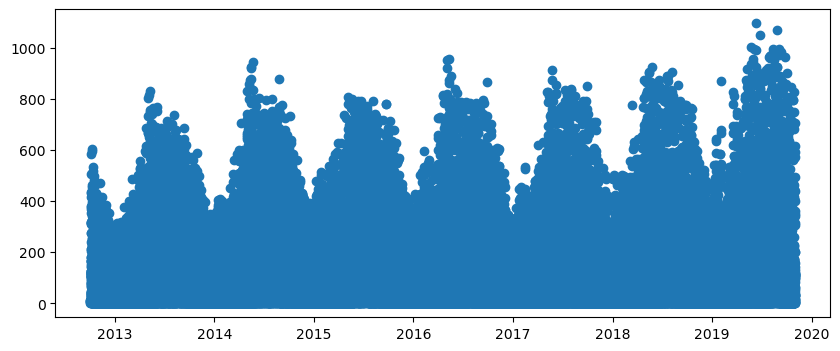

In [9]:
# Hourly plot
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(df_hourly["ds"], df_hourly["y"])
plt.show()

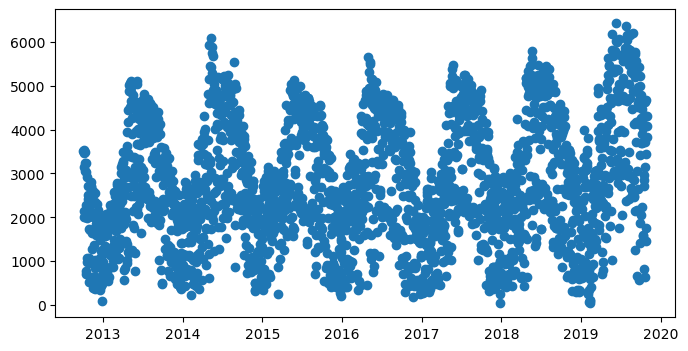

In [10]:
# Daily plot
fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(df_daily["ds"], df_daily["y"])
plt.show()

In [11]:
# Save weekly pattern
fig.savefig("daily_pattern.png", dpi = 300, bbox_inches = 'tight')

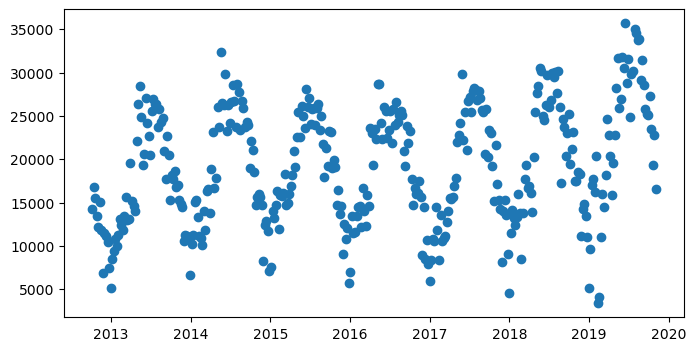

In [29]:
# Weekly plot
fig, ax = plt.subplots(figsize = (8, 4))
ax.scatter(df_weekly["ds"], df_weekly["y"])
plt.show()

# Building daily forecast

### Adding holidays

In [12]:
from prophet.make_holidays import make_holidays_df

year_list = df_daily['ds'].dt.year.unique().tolist()

# Identify the final year, as an integer, and increase it by 2
year_list.append(year_list[-1] + 2)
holidays = make_holidays_df(year_list = year_list,
                            country = 'US',
                            state = 'WA')

### Training model

16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing


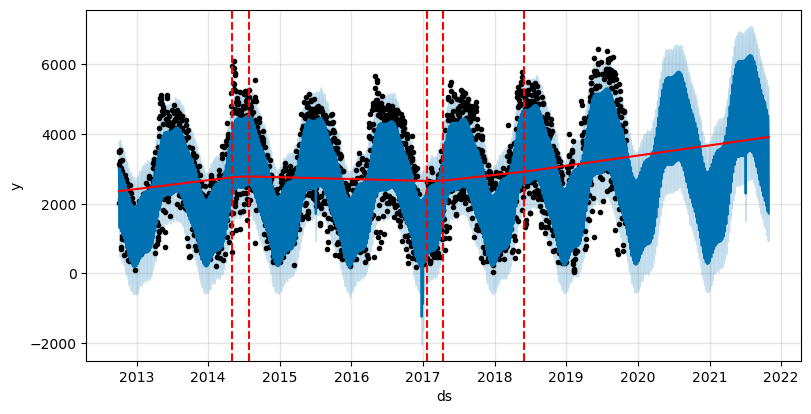

In [13]:
model = Prophet(seasonality_mode = 'multiplicative',
                yearly_seasonality = 4,
                holidays = holidays)

model.fit(df_daily) # on daily dataset
future = model.make_future_dataframe(periods = 365 * 2, freq = "D") # Frequency Daily
forecast = model.predict(future)
fig = model.plot(forecast)
fig.set_size_inches(8, 4)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [14]:
# Saving figure
fig.savefig("forecastplot.png", dpi = 400, bbox_inches = "tight")

In [15]:
fig = plot_plotly(model, forecast, trend = True, changepoints = True)
py.iplot(fig)

### Model saving and loading

In [16]:
with open('Seattle_bicycle_count_model.json', 'w') as file_out:
    json.dump(model_to_json(model), file_out)

In [17]:
with open('Seattle_bicycle_count_model.json', 'r') as file_in:
    model = model_from_json(json.load(file_in))

/home/rahul-raoniar/miniconda3/envs/datascience/lib/python3.9/site-packages/prophet/serialize.py:160: FutureWarning:

The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')



##### Component plot

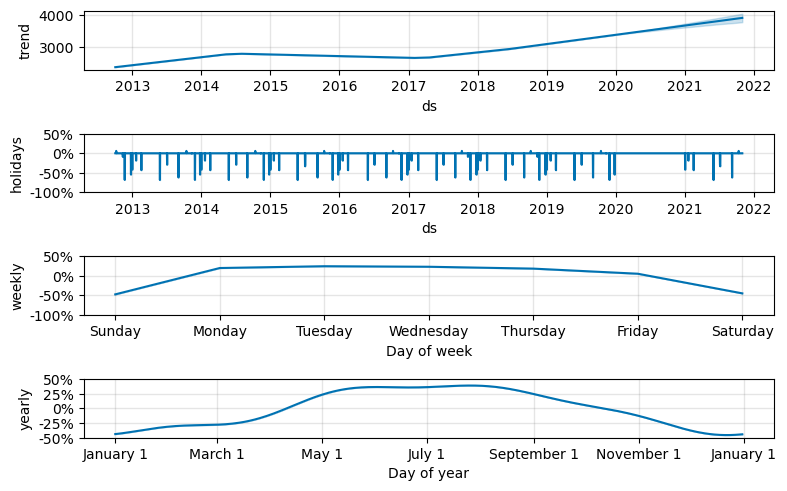

In [25]:
fig2 = model.plot_components(forecast, figsize = (8, 5))
# or fig2 = plot_components(model, forecast)
plt.show()

In [26]:
# Saving figure
fig2.savefig("components_plot.png", dpi = 400, bbox_inches = "tight")

In [20]:
fig = plot_components_plotly(model,
                             forecast,
                             figsize = (800, 175))
py.iplot(fig)

### Cross validation

In [21]:
df_cv = cross_validation(model, 
                        horizon = '90 days',     # forecast period
                        period = '30 days',      # 
                        initial = '730 days',    # Initial days
                        parallel = 'processes')  # Parellel processing

df_cv.head()

16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-10-28,3241.306125,2521.611260,4017.027818,2261.0,2014-10-27
1,2014-10-29,3148.649586,2339.775253,3923.213591,3396.0,2014-10-27
2,2014-10-30,2975.042840,2223.657220,3683.588578,2392.0,2014-10-27
3,2014-10-31,2636.767184,1904.685484,3364.033249,1938.0,2014-10-27
4,2014-11-01,1244.238404,566.712187,1999.882474,1294.0,2014-10-27


### Calculating model performance metric

In [22]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,499587.496670,706.815037,543.982905,0.480938,0.161940,0.260446,0.758945
1,10 days,512860.054432,716.142482,550.901640,0.487890,0.165703,0.265207,0.751412
2,11 days,486933.145310,697.805951,541.573077,0.465018,0.165703,0.259797,0.755179
3,12 days,493524.098215,702.512703,547.531629,0.457610,0.165646,0.258931,0.738230
4,13 days,483508.446177,695.347716,539.377303,0.452137,0.161356,0.252900,0.749529


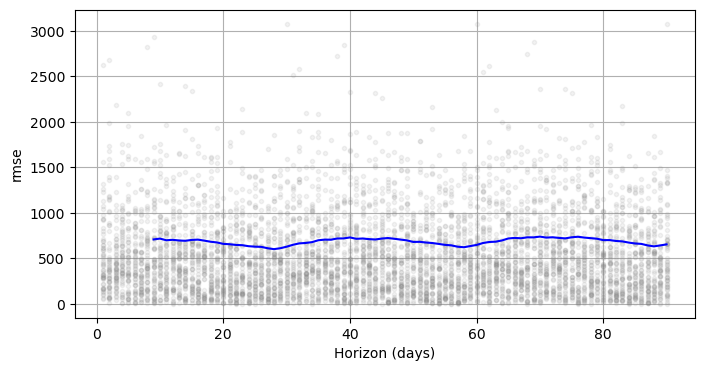

In [27]:
# Showing cross validation metric plot
fig = plot_cross_validation_metric(df_cv,
                                   metric = 'rmse',
                                   rolling_window = 0.1)
fig.set_size_inches(8, 4)
plt.show()

In [28]:
# Saving figure
fig.savefig("cross_validation_plot.png", dpi = 400, bbox_inches = "tight")